In [1]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 100
rcParams["savefig.dpi"] = 150

import numpy as np
#import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
from maelstrom import Maelstrom

red = '#e41a1c'
blue = '#377eb8'
green = '#4daf4a'
purple = '#984ea3'
orange = '#ff7f00'

In [2]:
from maelstrom.synthetic import SyntheticBinary

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c27a74400>,
      dtype=object)

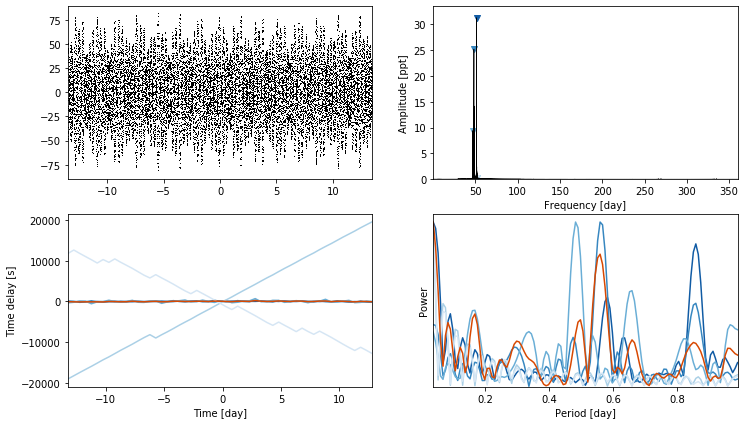

In [6]:
# Check time delay signal is injected properly
period = 30.
eccen = 0.5
asini = 100
varpi = 1.
tref = 0.

n_freq = 5
freqs = np.random.normal(loc=50., scale=2., size=n_freq)
amps = np.random.normal(loc=0.01, scale=0.01, size=n_freq)

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period, eccen, asini, varpi, tref)
#lc.add_noise(noise=4.)

ms = Maelstrom(lc.time, lc.flux, max_peaks=5)
ms.first_look(segment_size=0.5)

In [67]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

class SyntheticBinary(object):
    """
    This class makes a synthetic light curve and injects a time delay signal corresponding to the input binary orbit parameters    
    """
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, tref):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.tref = period, eccen, asini, varpi, tref
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            #M = tt.zeros_like(tt.constant(self.time) - self.tref) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            M = 2.0 * np.pi * (tt.constant(self.time) - self.tref) / self.period
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = (- (1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in zip(self.freq, self.amplitude):
            omega = 2 * np.pi * j
            self.flux_true += A_j * np.cos(omega * (self.time - self.tau)) + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, snr=5):
        # Add noise
        np.random.seed(42)
        s_rms = self.amplitude / (np.sqrt(np.pi / len(self.time)) * snr)
        #print(s_rms, self.amplitude)
        #print(np.random.normal(loc=0.0, scale=s_rms, size=len(self.time)))
        self.flux = self.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(self.time))
        #self.flux_err = noise * np.std(self.flux_true)
        #self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))

In [68]:
lc.flux

array([1.19083145e+08, 1.19083145e+08, 1.19083145e+08, ...,
       1.19083145e+08, 1.19083145e+08, 1.19083145e+08])

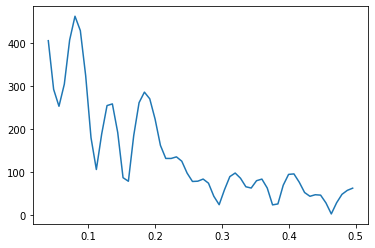

In [110]:
# Check time delay signal is injected properly
period = 10.
eccen = 0.
asini = 500
varpi = 1.
tref = 0.

n_freq = 1
np.random.seed(42)
freqs = np.random.normal(40, 20, size=n_freq)

np.random.seed(23)
amps = np.random.normal(0.001, 0.01, size=n_freq)

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period, eccen, asini, varpi, tref)
lc.add_noise(snr=5)

ms = Maelstrom(lc.time, lc.flux, freq=freqs)
td_time, td_td = ms.get_time_delay(segment_size=1)
#plt.scatter(td_time, td_td)
plt.plot(*amplitude_spectrum(td_time, td_td[:,0]))

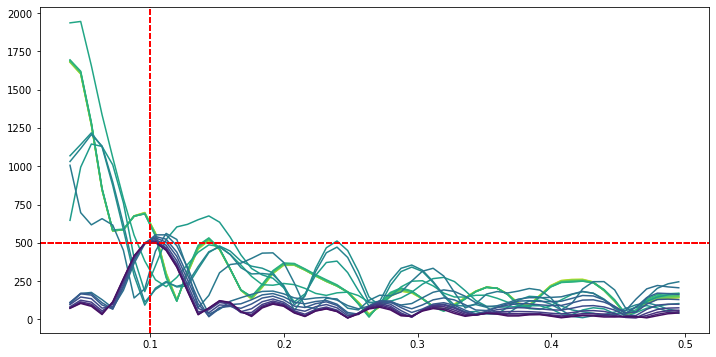

In [137]:
# Check time delay signal is injected properly
fig, ax = plt.subplots(figsize=[12,6])
period = 10.
eccen = 0.
asini = 500
varpi = 1.
tref = 0.

n_freq = 1
freqs = [40]
amps = [0.001]


# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

import tqdm
#snrs = np.linspace(1,20,100)
snrs = np.append([0],np.geomspace(0.1,20,20))

f_found = []
a_found = []
for snr, color in zip(snrs, unique_colors(len(snrs), cmap="viridis")[::-1]):
    lc = SyntheticBinary(time, freqs, amps,
                         period, eccen, asini, varpi, tref)
    lc.add_noise(snr=snr)
    ms = Maelstrom(lc.time, lc.flux, freq=freqs)
    td_time, td_td = ms.get_time_delay(segment_size=1)
    #plt.scatter(td_time, td_td)
    nn, aa = amplitude_spectrum(td_time, td_td[:,0])
    ax.plot(nn, aa, c=color)
    ax.axvline(1/period, c='r', linestyle='--')
    ax.axhline(asini, c='r', linestyle='--')
    ind = np.argmax(aa)
    f_found.append(nn[ind])
    a_found.append(aa[ind])

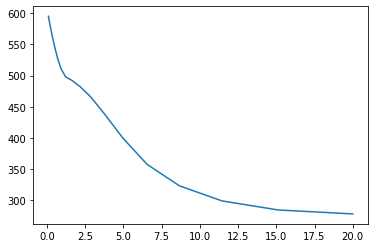

In [135]:
plt.plot(snrs, a_found)

In [114]:
from maelstrom.utils import unique_colors

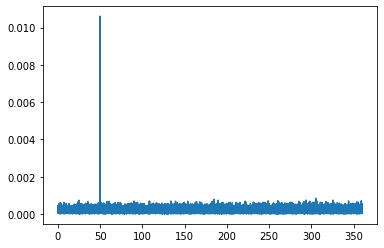

In [83]:
from maelstrom.utils import amplitude_spectrum

plt.plot(*amplitude_spectrum(lc.time, lc.flux))

In [84]:
np.random.normal(loc=0.0, scale=)

SyntaxError: invalid syntax (<ipython-input-84-7c1718c3b174>, line 1)

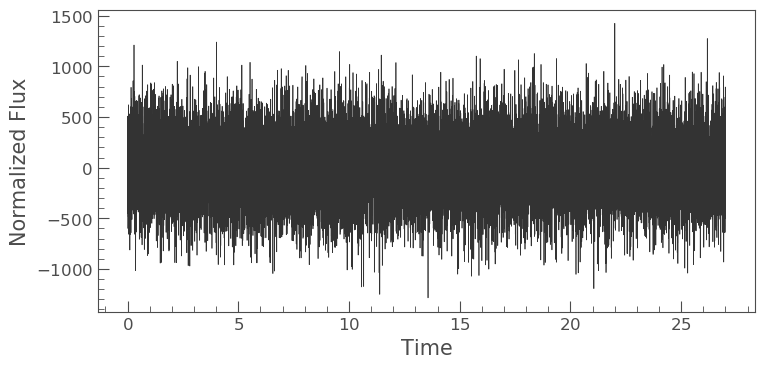

In [88]:
import lightkurve as lk

lc2 = lk.LightCurve(lc.time, lc.flux)
lc2.plot()

/Users/danielhey/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:752: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)


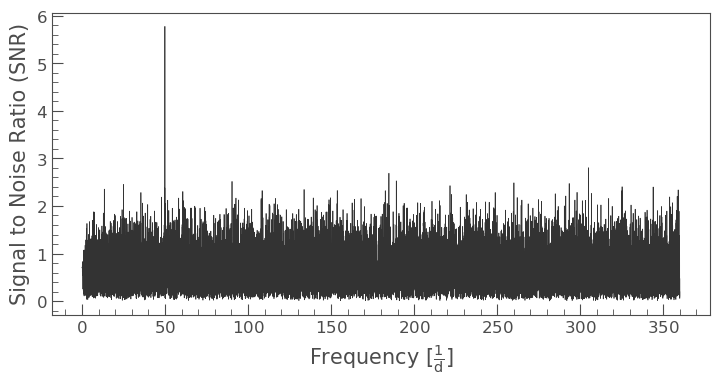

In [89]:
lc2.to_periodogram().flatten().plot()